# Santiago's pois time to database

This notebook loads specific points (already filtered and classified for a given source of interest in Notebooks starting with 03 or externally) and a source_name, calculates and loads into database the time from each node in Santiago, Chile to its closest pois using __function analysis>pois_time()__ as well as the amount of amenities at a 15 minute walk from each node (__count_pois = (True,15)__).

This notebook helped develop __Script 23-proximity-analysis-progressive.py__

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [96]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [70]:
# general pois local dir
gral_dir = '../../../data/external/temporal_fromjupyter/santiago/pois/'

# Name of pois to be examined (source_name)
source = 'vacunatorio_pub'

# Directory where pois to be examined are located
pois_dir = gral_dir + f'{source}.gpkg'

# Pois proximity methodology - Count pois at a given time proximity?
count_pois = (True,15)

# Area of interest (Run bigger since we can clip data as soon as we know inputs extent)
city = 'AM_Santiago'

# Save output
save_schema = 'projects_research'
nodes_save_table = 'santiago_nodesproximity'

# Save space in disk by deleting data that won't be used again?
save_space = True

In [95]:
# Already ran:
# private clinics 
#        (clinica_priv.gpkg, code 'clinica_priv')
# public clinics 
#        (clinica_pub.gpkg, code 'clinica_pub')
# private audiologist, dentist, optician 
#        (consult_ado_priv.gpkg, code consult_ado_priv)
# public audiologist, dentist, optician 
#        (consult_ado_pub.gpkg, code consult_ado_pub)
# private hospital 
#        (hospital_priv.gpkg, code hospital_priv)
# public hospital 
#        (hospital_pub.gpkg, code hospital_pub)
# private vaccination center 
#        (vacunatorio_priv.gpkg, code vacunatorio_priv)
# public vaccination center 
#        (vacunatorio_pub.gpkg, code vacunatorio_pub)

## Required data for pois_time

In [29]:
# Database schemas and tables (Shouldn't change for this project)
# Area of interest (aoi)
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
# OSMnx Network
network_schema = 'projects_research'
edges_table = 'santiago_edges'
nodes_table = 'santiago_nodes'
projected_crs = 'EPSG:32719'

#### Area of interest and OSMnx Network

<Axes: >

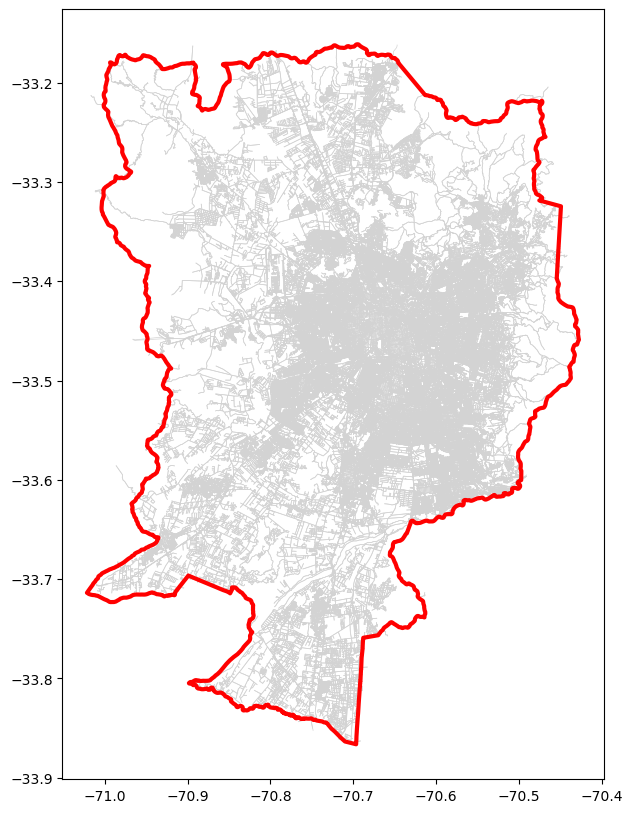

In [6]:
# Area of interest (aoi)
query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

# OSMnx Network
G, nodes, edges = aup.graph_from_hippo(aoi, network_schema, edges_table, nodes_table, projected_crs)

# Show
fig,ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

#### Points of interest (pois)

In [71]:
# Load all pois from pois_dir
pois = gpd.read_file(pois_dir)
pois = pois[['code','geometry']]
pois = pois.set_crs("EPSG:4326")

# Clip pois to aoi
source_pois = gpd.sjoin(pois, aoi)
source_pois = source_pois[['code','geometry']]

if save_space:
    del pois

# Show
print(source_pois.shape)
source_pois.head(2)

(1, 2)


,code,geometry
0,vacunatorio_publico,POINT (-70.62259 -33.43649)


## Calculate node proximity (pois_time)

In [72]:
# 2.3 --------------- SOURCE ANALYSIS
# Calculate time data from nodes to source
source_nodes_time = aup.pois_time(G, nodes, edges, source_pois, source, prox_measure='length', count_pois=count_pois, projected_crs=projected_crs)
source_nodes_time.rename(columns={'time_'+source:source},inplace=True)
nodes_analysis = source_nodes_time.copy()

if save_space:
    del source_nodes_time

# 2.4 --------------- OUTPUT MERGE
# From Script, not needed if just running one source at a time

# 2.5 --------------- Final format for nodes
# if count_pois, include generated col
if count_pois[0]:
    column_order = ['osmid'] + [source, f'{source}_{count_pois[1]}min'] + ['x','y','geometry']
else:
    column_order = ['osmid'] + [source] + ['x','y','geometry']
nodes_analysis = nodes_analysis[column_order]

# Show
print(nodes_analysis.shape)
nodes_analysis.head(2)

Found and assigned nearest node osmid to each vacunatorio_pub.
Starting time analysis for vacunatorio_pub.
Starting range k = 1 of 1 for vacunatorio_pub.
Finished time analysis for vacunatorio_pub.
(257999, 6)


,osmid,vacunatorio_pub,vacunatorio_pub_15min,x,y,geometry
0,14609420,258.924795,0.0,-70.754779,-33.515980,POINT (-70.75478 -33.51598)
1,266256899,313.769730,0.0,-70.795942,-33.522296,POINT (-70.79594 -33.52230)


In [9]:
# Show
#fig,ax = plt.subplots(figsize=(10,10))
#nodes_analysis.plot(f'{source}_{count_pois[1]}min',ax=ax,zorder=2,markersize=3)
#aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

## Prepare for upload to database (To save pois as inputs are confirmed, should be saved as tidy data)

In [73]:
# Add source column to be able to extract source proximity data
nodes_analysis['source'] = source
# Rename source-specific column names as name that apply to all sources
nodes_analysis.rename(columns={source:'source_time',
                               f'{source}_{count_pois[1]}min':'source_15min'},inplace=True)
# Set column order
nodes_analysis = nodes_analysis[['osmid','source','source_time','source_15min','x','y','geometry']]

# Show
print(nodes_analysis.shape)
nodes_analysis.head(2)

(257999, 7)


,osmid,source,source_time,source_15min,x,y,geometry
0,14609420,vacunatorio_pub,258.924795,0.0,-70.754779,-33.515980,POINT (-70.75478 -33.51598)
1,266256899,vacunatorio_pub,313.769730,0.0,-70.795942,-33.522296,POINT (-70.79594 -33.52230)


## Save to database

In [74]:
if save:
    nodes_analysis['city'] = city
    aup.gdf_to_db_slow(nodes_analysis, nodes_save_table, save_schema, if_exists='append')
    
    if save_space:
        del nodes_analysis

## Error fix

In [ ]:
# Previously fixed errors:

# Changing code 'clinica_private' to 'clinica_priv'
#idx = saved_data['source'] == 'clinica_private'
#saved_data.loc[idx,'source'] = 'clinica_priv'

# Changing code 'clinica_public' to 'clinica_pub'
#idx = saved_data['source'] == 'clinica_public'
#saved_data.loc[idx,'source'] = 'clinica_pub'

In [94]:
# Load currently saved data
#query = f"SELECT * FROM {save_schema}.{nodes_save_table}"
#saved_data = aup.gdf_from_query(query, geometry_col='geometry')

# Show
#print(saved_data.shape)
#saved_data.head(2)

In [91]:
#if save:
#    aup.gdf_to_db_slow(saved_data, nodes_save_table, save_schema, if_exists='replace')
    
#    if save_space:
#        del saved_data